In [2]:
from pathlib import Path

DATASET_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

# Check dataset exists
print("Directory exists:", DATASET_DIR.exists())

# List classes
classes = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
print("Total classes:", len(classes))
print(classes)


Directory exists: True
Total classes: 10
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [3]:
from pathlib import Path
import pandas as pd

DATASET_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

image_paths = []
labels = []

# Load all image paths
for cls in sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()]):
    cls_dir = DATASET_DIR / cls
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG"):
        for fp in cls_dir.glob(ext):
            image_paths.append(fp)
            labels.append(cls)

print("Total images found:", len(image_paths))

# Per-class count table
df_counts = pd.DataFrame(labels, columns=["class"]).value_counts().reset_index()
df_counts.columns = ["class", "count"]

print("\nPer-class image counts:")
print(df_counts)


Total images found: 14529

Per-class image counts:
                                           class  count
0         Tomato___Tomato_Yellow_Leaf_Curl_Virus   4286
1                        Tomato___Bacterial_spot   1702
2                           Tomato___Late_blight   1527
3                    Tomato___Septoria_leaf_spot   1417
4  Tomato___Spider_mites Two-spotted_spider_mite   1341
5                               Tomato___healthy   1273
6                           Tomato___Target_Spot   1123
7                          Tomato___Early_blight    800
8                             Tomato___Leaf_Mold    761
9                   Tomato___Tomato_mosaic_virus    299


In [ ]:
# Feature extraction  and save to .npz
from pathlib import Path
import numpy as np
from tqdm import tqdm
import cv2
from skimage.feature import hog
import os

# ---------- Config ----------
DATASET_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")
OUT_PATH = Path("/kaggle/working/features.npz")
IMG_SIZE = (128, 128)   
HIST_BINS = 32
MAX_SAMPLES = None    
 

# ---------- build image list if not already present ----------
try:
    image_paths   
    labels
except NameError:
    image_paths = []
    labels = []
    for cls in sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()]):
        cls_dir = DATASET_DIR / cls
        for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG"):
            for fp in cls_dir.glob(ext):
                image_paths.append(fp)
                labels.append(cls)

print("Total images available:", len(image_paths))
if MAX_SAMPLES:
    image_paths = image_paths[:MAX_SAMPLES]
    labels = labels[:MAX_SAMPLES]
    print("Using MAX_SAMPLES =", MAX_SAMPLES)

# ---------- feature extractor ----------
def extract_features(image_path, img_size=IMG_SIZE, hist_bins=HIST_BINS):
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    # color histogram per channel 
    chans = cv2.split(img)
    hist_features = []
    for ch in chans:
        h = cv2.calcHist([ch], [0], None, [hist_bins], [0, 256])
        h = cv2.normalize(h, h).flatten()
        hist_features.extend(h)
    # HOG features  
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_feat = hog(gray, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
    features = np.concatenate([np.array(hist_features), hog_feat])
    return features

# ---------- extraction loop ----------
feat_list = []
lbl_list = []
path_list = []
skipped = 0

for fp, lab in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Extracting features"):
    f = extract_features(fp)
    if f is None:
        skipped += 1
        continue
    feat_list.append(f)
    lbl_list.append(lab)
    path_list.append(str(fp))

print(f"Done. Extracted features for {len(feat_list)} images, skipped {skipped} images.")

# ---------- stack and save ----------
if len(feat_list) == 0:
    raise RuntimeError("No features extracted ")

X = np.vstack(feat_list).astype(np.float32)
y = np.array(lbl_list)
paths = np.array(path_list)

print("Feature matrix shape:", X.shape)
print("Feature vector length:", X.shape[1])
os.makedirs(OUT_PATH.parent, exist_ok=True)
np.savez_compressed(OUT_PATH, X=X, y=y, paths=paths)
print("Saved features to:", OUT_PATH)

# ---------- quick per-class summary ----------
unique_labels, counts = np.unique(y, return_counts=True)
print("\nPer-class counts in extracted set:")
for ul, c in zip(unique_labels, counts):
    print(f"{ul}: {c}")

 


Total images available: 14529


Extracting features: 100%|██████████| 14529/14529 [02:12<00:00, 109.61it/s]


Done. Extracted features for 14529 images, skipped 0 images.
Feature matrix shape: (14529, 1860)
Feature vector length: 1860
Saved features to: /kaggle/working/features.npz

Per-class counts in extracted set:
Tomato___Bacterial_spot: 1702
Tomato___Early_blight: 800
Tomato___Late_blight: 1527
Tomato___Leaf_Mold: 761
Tomato___Septoria_leaf_spot: 1417
Tomato___Spider_mites Two-spotted_spider_mite: 1341
Tomato___Target_Spot: 1123
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286
Tomato___Tomato_mosaic_virus: 299
Tomato___healthy: 1273


In [ ]:
#  features, encode labels, split, train RandomForest  
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

FEATURE_FILE = "/kaggle/working/features.npz"

# ---------- Load extracted features ----------
data = np.load(FEATURE_FILE, allow_pickle=True)
X = data["X"]
y_raw = data["y"]

print("Loaded:", FEATURE_FILE)
print("X shape:", X.shape)
print("Example feature length:", X.shape[1])

# ---------- Encode labels ----------
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_

print("Classes:", list(class_names))

# ----------  split ----------
 
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

#  split  
val_ratio = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# ---------- RandomForest Pipeline ----------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# small GridSearch (fast)
param_grid = {
    "rf__max_depth": [None, 30],
    "rf__min_samples_leaf": [1, 2],
    "rf__class_weight": [None, "balanced"]
}

print("Running GridSearchCV...")
gs = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("\nBest Params:", gs.best_params_)
print("Best CV Accuracy:", gs.best_score_)

# ---------- Validation Performance ----------
val_pred = gs.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)

print("\nValidation Accuracy:", val_acc)
print("\nValidation Classification Report:")
print(classification_report(y_val, val_pred, target_names=class_names))


Loaded: /kaggle/working/features.npz
X shape: (14529, 1860)
Example feature length: 1860
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Train: (10169, 1860)
Val: (2180, 1860)
Test: (2180, 1860)
Running GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best Params: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 2}
Best CV Accuracy: 0.8134533816242207

Validation Accuracy: 0.8279816513761468

Validation Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.87      0.81      0.84       256
                        Tomato___Early_blight       0.83      0.37      0.51  

Test accuracy: 0.8174



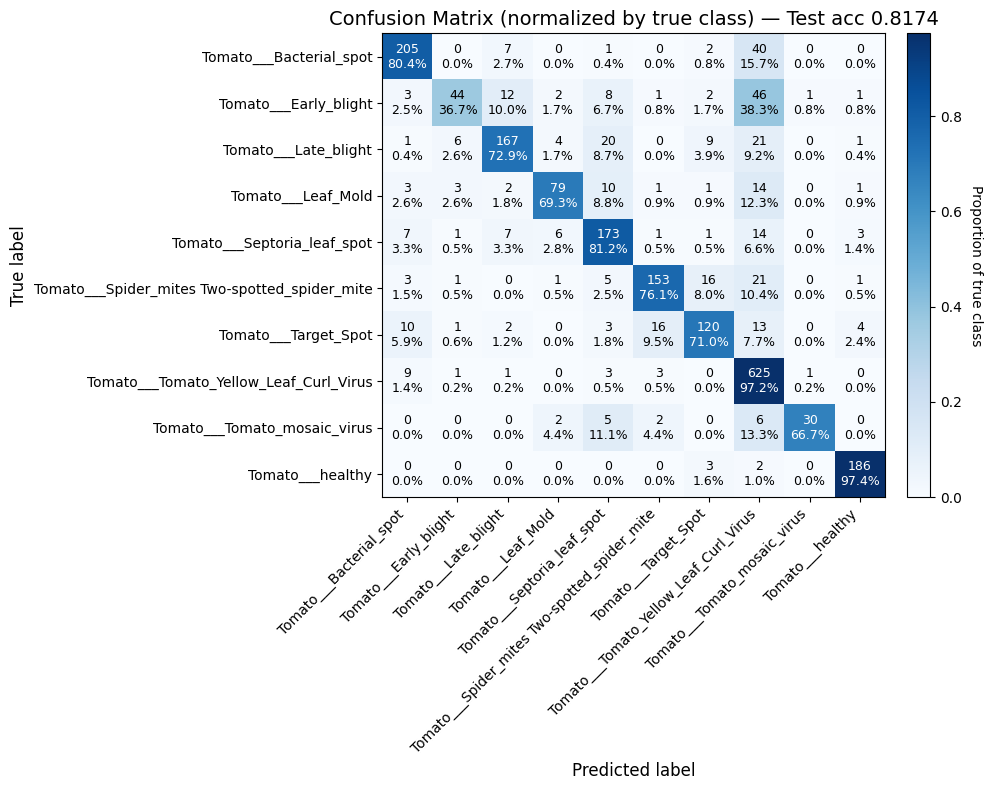

Saved confusion matrix to: /kaggle/working/confusion_matrix_test.png

Per-class metrics (rounded):


precision  recall     f1  \
class                                                                     
Tomato___Bacterial_spot                            0.851   0.804  0.827   
Tomato___Early_blight                              0.772   0.367  0.497   
Tomato___Late_blight                               0.843   0.729  0.782   
Tomato___Leaf_Mold                                 0.840   0.693  0.760   
Tomato___Septoria_leaf_spot                        0.759   0.812  0.785   
Tomato___Spider_mites Two-spotted_spider_mite      0.864   0.761  0.810   
Tomato___Target_Spot                               0.779   0.710  0.743   
Tomato___Tomato_Yellow_Leaf_Curl_Virus             0.779   0.972  0.865   
Tomato___Tomato_mosaic_virus                       0.938   0.667  0.779   
Tomato___healthy                                   0.944   0.974  0.959   

                                               support  
class                                                   
Tomato___Bacterial_spot                            255  
Tomato___Early_blight                              120  
Tomato___Late_blight                               229  
Tomato___Leaf_Mold                                 114  
Tomato___Septoria_leaf_spot                        213  
Tomato___Spider_mites Two-spotted_spider_mite      201  
Tomato___Target_Spot                               169  
Tomato___Tomato_Yellow_Leaf_Curl_Virus             643  
Tomato___Tomato_mosaic_virus                        45  
Tomato___healthy                                   191

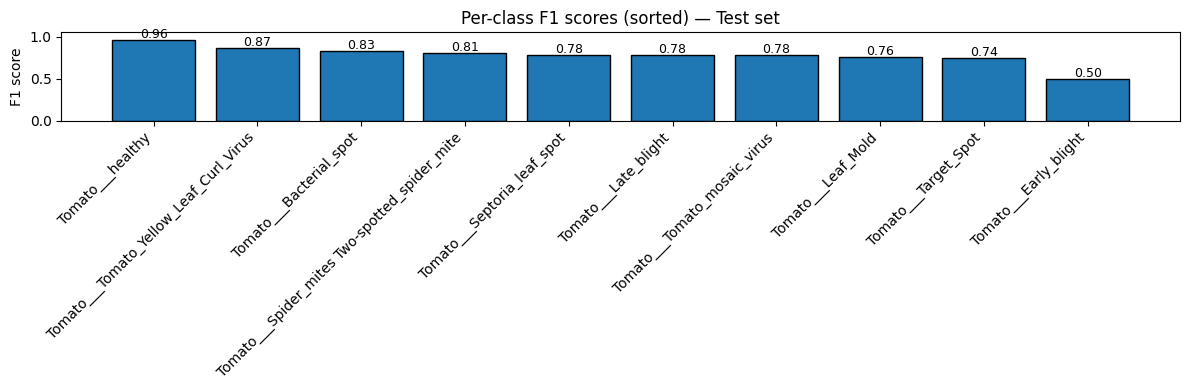

Saved F1 plot to: /kaggle/working/per_class_f1_sorted.png


In [ ]:
#   Confusion Matrix  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# --- Precondition: assumes `gs`, `X_test`, `y_test`, `class_names` exist in notebook ---
# If best estimator object is inside GridSearch 'gs'
model = gs.best_estimator_

# Predictions and accuracy
y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}\n")

# --- Confusion matrix (counts + per-class percent) ---
cm = confusion_matrix(y_test, y_pred)
row_sums = cm.sum(axis=1, keepdims=True)           # true-class totals
cm_pct = np.divide(cm, row_sums, where=row_sums!=0)

n = len(class_names)
figsize = (max(10, n * 0.9), max(8, n * 0.5))
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(cm_pct, cmap="Blues", aspect="auto")

# ticks and labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(class_names, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
ax.set_title(f"Confusion Matrix (normalized by true class) — Test acc {test_acc:.4f}", fontsize=14)

# colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Proportion of true class", rotation=270, labelpad=15)

 
thresh = cm_pct.max() / 2.0
for i in range(n):
    for j in range(n):
        cnt = int(cm[i, j])
        pct = cm_pct[i, j]
        text = f"{cnt}\n{pct:.1%}"
        ax.text(j, i, text, ha="center", va="center",
                color="white" if cm_pct[i, j] > thresh else "black", fontsize=9)

plt.tight_layout()
fig_path = "/kaggle/working/confusion_matrix_test.png"
fig.savefig(fig_path, dpi=200)
plt.show()
print("Saved confusion matrix to:", fig_path)

# --- Per-class F1 bar chart ---
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, zero_division=0)
metrics_df = pd.DataFrame({
    "class": class_names,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": sup.astype(int)
}).set_index("class")

print("\nPer-class metrics (rounded):")
display(metrics_df.round(3))

# Sorted bar chart by F1  
metrics_sorted = metrics_df.sort_values("f1", ascending=False)
plt.figure(figsize=(12, 4))
bars = plt.bar(range(len(metrics_sorted)), metrics_sorted["f1"], edgecolor="k")
plt.xticks(range(len(metrics_sorted)), metrics_sorted.index, rotation=45, ha="right", fontsize=10)
plt.ylim(0, 1.05)
plt.ylabel("F1 score")
plt.title("Per-class F1 scores (sorted) — Test set", fontsize=12)
for idx, b in enumerate(bars):
    v = metrics_sorted["f1"].iloc[idx]
    plt.text(b.get_x() + b.get_width()/2, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)
plt.tight_layout()
bar_path = "/kaggle/working/per_class_f1_sorted.png"
plt.savefig(bar_path, dpi=200)
plt.show()
print("Saved F1 plot to:", bar_path)


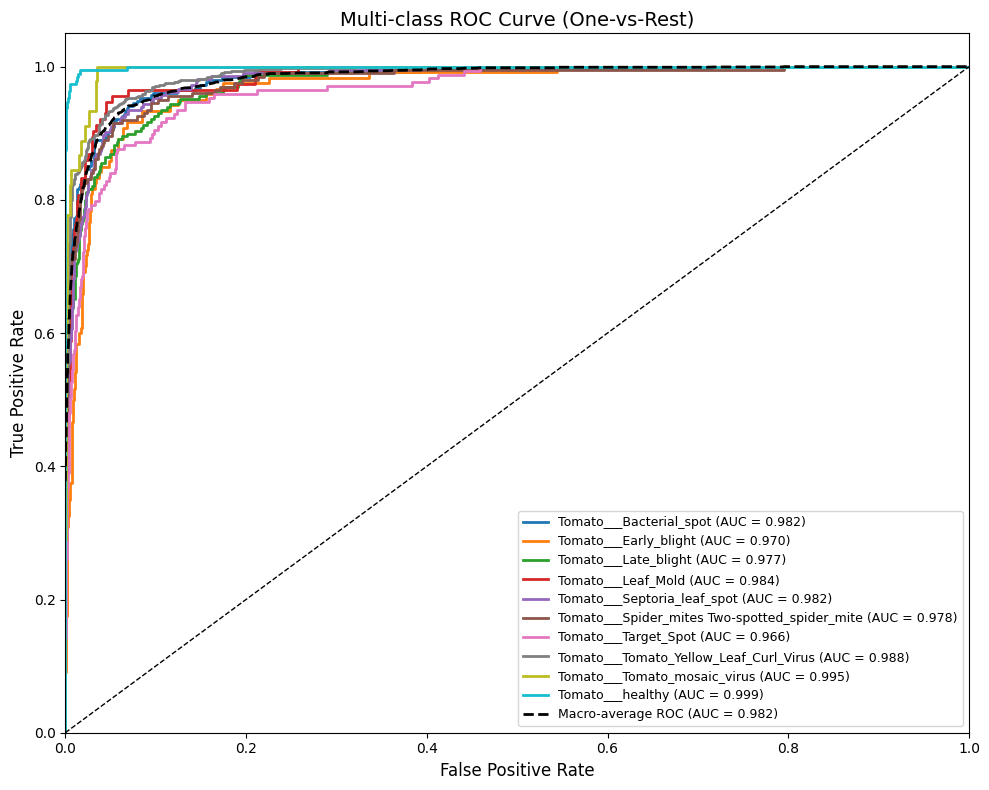

ROC Curve saved to: /kaggle/working/roc_curves.png


In [ ]:
#  ROC Curve  

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# --- Ensure model and test data exist ---
model = gs.best_estimator_

# --- Binarize labels for multi-class ROC ---
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

# Predict probability for each class
y_score = model.predict_proba(X_test)

n_classes = len(class_names)
plt.figure(figsize=(10, 8))

# Store macro-average items
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# Plot each class ROC
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    plt.plot(fpr_dict[i], tpr_dict[i],
             lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc_dict[i]:.3f})")

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color="black", linestyle="--",
         label=f"Macro-average ROC (AUC = {macro_auc:.3f})", linewidth=2)

# Formatting
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-class ROC Curve (One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()

save_path = "/kaggle/working/roc_curves.png"
plt.savefig(save_path, dpi=200)
plt.show()

print("ROC Curve saved to:", save_path)


Recreated splits -> train: 10169, val: 2180, test: 2180
Using model from 'gs.best_estimator_'.
Misclassified on test set: 398 samples


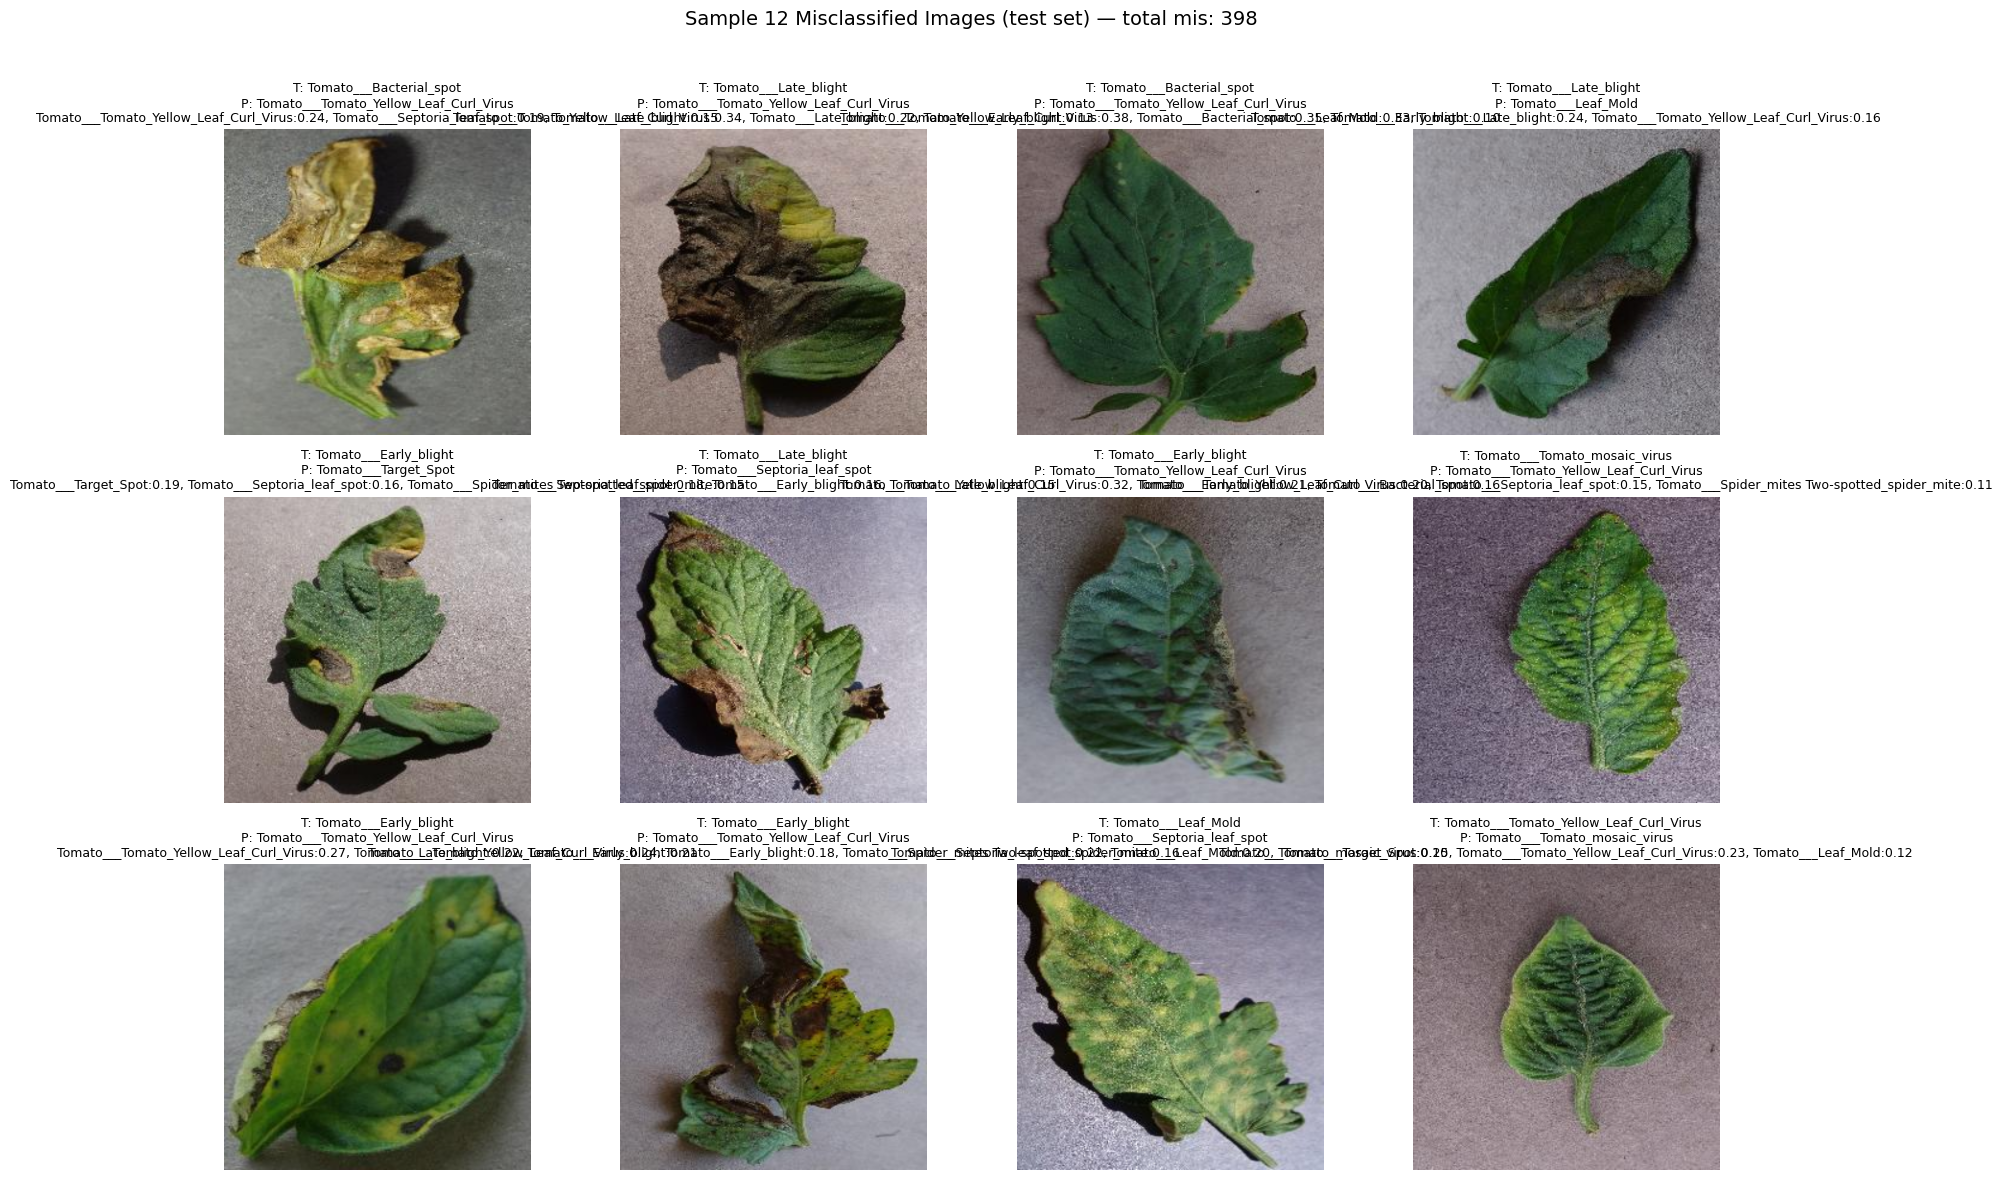

Saved sampled misclassified images to: /kaggle/working/misclassified_samples


In [ ]:
#   Misclassified images  
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

SAMPLE_N = 12   
OUT_DIR = "/kaggle/working/misclassified_samples"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load features ---
FEATURE_FILE = "/kaggle/working/features.npz"
data = np.load(FEATURE_FILE, allow_pickle=True)
X_all = data["X"]
y_raw_all = data["y"]
paths_all = data["paths"].astype(str)

# --- encode labels consistently ---
le = LabelEncoder()
y_all = le.fit_transform(y_raw_all)
class_names = le.classes_
n_classes = len(class_names)

 
rng = 42
idx = np.arange(len(y_all))

# first split out test (15%)
idx_temp, idx_test = train_test_split(idx, test_size=0.15, random_state=rng, stratify=y_all)
 
val_ratio = 0.15 / 0.85
idx_train, idx_val = train_test_split(idx_temp, test_size=val_ratio, random_state=rng, stratify=y_all[idx_temp])

# prepare test arrays
X_test_local = X_all[idx_test]
y_test_local = y_all[idx_test]
paths_test = paths_all[idx_test]

print(f"Recreated splits -> train: {len(idx_train)}, val: {len(idx_val)}, test: {len(idx_test)}")

 
try:
    model = gs.best_estimator_
    print("Using model from 'gs.best_estimator_'.")
except Exception:
    # fallback path  
    fallback = "/kaggle/working/rf_plantvillage/rf_pipeline.joblib"
    if os.path.exists(fallback):
        model = joblib.load(fallback)
        print("Loaded model from", fallback)
    else:
        raise RuntimeError("Model not found: neither gs.best_estimator_ nor joblib fallback exists.")

# --- predictions and probabilities ---
y_pred = model.predict(X_test_local)
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test_local)
else:
 
    try:
        scores = model.decision_function(X_test_local)
        # apply softmax-like conversion for multi-class - 
        exp = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        y_proba = exp / exp.sum(axis=1, keepdims=True)
    except Exception:
        y_proba = None

# --- find misclassified indices ---
mis_mask = (y_pred != y_test_local)
mis_indices = np.where(mis_mask)[0]
n_mis = len(mis_indices)
print(f"Misclassified on test set: {n_mis} samples")

if n_mis == 0:
    print("No misclassified samples found. Good job!")
else:
    # sample some indices to display
    sample_n = min(SAMPLE_N, n_mis)
    sampled = random.sample(list(mis_indices), sample_n)

    # plotting grid
    cols = 4
    rows = int(np.ceil(sample_n / cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i, idx_local in enumerate(sampled):
        img_path = paths_test[idx_local]
        true_label = class_names[y_test_local[idx_local]]
        pred_label = class_names[y_pred[idx_local]]

        # read image for display
        img = cv2.imread(img_path)
        if img is None:
            # placeholder image if read fails
            disp_img = np.ones((224,224,3), dtype=np.uint8) * 200
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # resize for consistent display
            h = 320
            aspect = img.shape[1] / img.shape[0]
            w = int(h * aspect)
            disp_img = cv2.resize(img, (w, h))

        # compute top-3 probs if available
        title_probs = ""
        if y_proba is not None:
            probs = y_proba[idx_local]
            topk_idx = np.argsort(probs)[::-1][:3]
            probs_str = ", ".join([f"{class_names[t]}:{probs[t]:.2f}" for t in topk_idx])
            title_probs = probs_str

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(disp_img)
        ax.axis("off")
        ax.set_title(f"T: {true_label}\nP: {pred_label}\n{title_probs}", fontsize=9)

        # save individual misclassified image with overlay filename
        save_name = os.path.join(OUT_DIR, f"mis_{i}_{os.path.basename(img_path)}")
        # convert back to BGR for cv2.imwrite
        try:
            save_img = cv2.cvtColor(disp_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(save_name, save_img)
        except Exception:
            pass

    plt.suptitle(f"Sample {sample_n} Misclassified Images (test set) — total mis: {n_mis}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print(f"Saved sampled misclassified images to: {OUT_DIR}")


Using model from GridSearch.


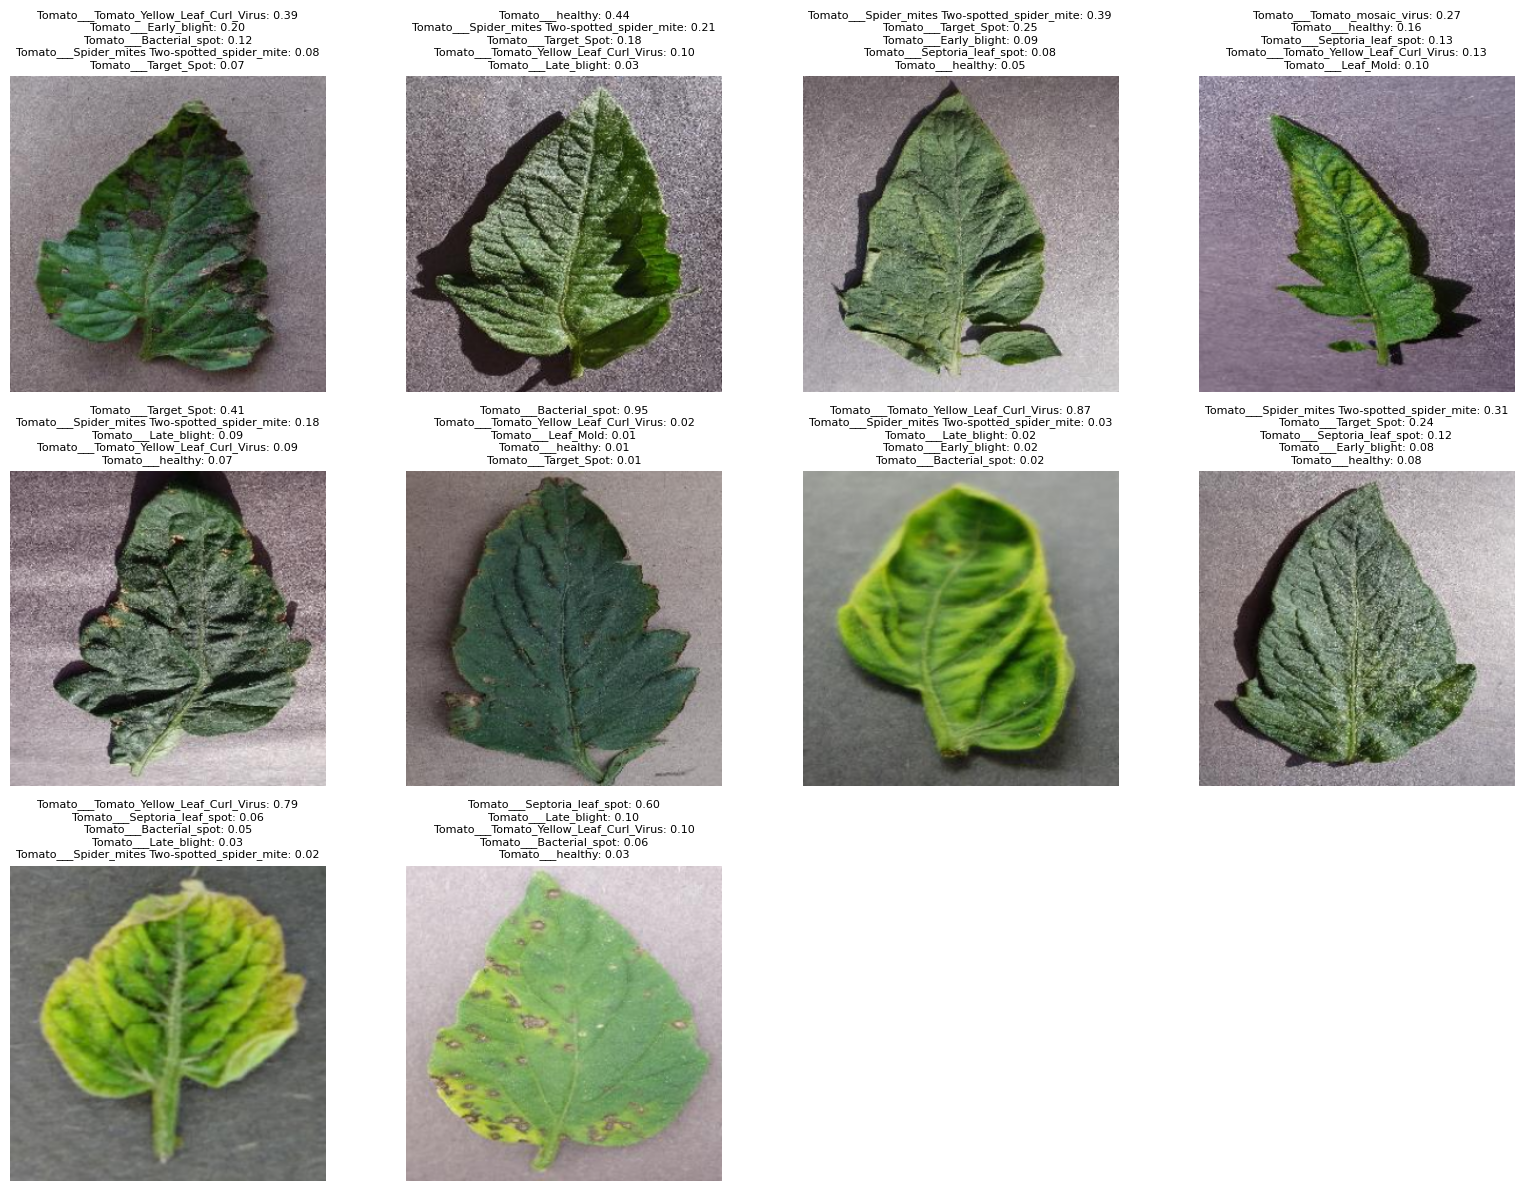

Saved sample Top-K prediction images to: /kaggle/working/topk_predictions


In [11]:
#  Top-5 predicted probabilities viewer for Test images
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

TOP_K = 5
SAMPLE_N = 10
OUT_DIR = "/kaggle/working/topk_predictions"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load feature file ---
FEATURE_FILE = "/kaggle/working/features.npz"
data = np.load(FEATURE_FILE, allow_pickle=True)
X_all = data["X"]
y_raw_all = data["y"]
paths_all = data["paths"].astype(str)

# --- Encode labels same as before ---
le = LabelEncoder()
y_all = le.fit_transform(y_raw_all)
class_names = le.classes_

# --- Recreate same train/val/test split ---
rng = 42
idx = np.arange(len(y_all))

# Step 1 — test split (15%)
idx_temp, idx_test = train_test_split(idx, test_size=0.15, random_state=rng, stratify=y_all)

# Step 2 — val split from remaining
val_ratio = 0.15 / 0.85
idx_train, idx_val = train_test_split(idx_temp, test_size=val_ratio, random_state=rng, stratify=y_all[idx_temp])

# final Test arrays
X_test_local = X_all[idx_test]
y_test_local = y_all[idx_test]
paths_test = paths_all[idx_test]

# --- Load model ---
try:
    model = gs.best_estimator_
    print("Using model from GridSearch.")
except:
    model = joblib.load("/kaggle/working/rf_plantvillage/rf_pipeline.joblib")
    print("Loaded saved RandomForest model.")

# --- Predict probability ---
y_proba = model.predict_proba(X_test_local)

# --- Random sample from test set ---
sample_indices = random.sample(range(len(X_test_local)), SAMPLE_N)

cols = 4
rows = int(np.ceil(SAMPLE_N / cols))
plt.figure(figsize=(4 * cols, 4 * rows))

for i, idx_local in enumerate(sample_indices):
    img_path = paths_test[idx_local]
    probs = y_proba[idx_local]

    # read image
    img = cv2.imread(img_path)
    if img is None:
        disp_img = np.ones((224, 224, 3), dtype=np.uint8) * 200
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        disp_img = cv2.resize(img, (300, 300))

    # Top-K predicted classes
    topk_idx = np.argsort(probs)[::-1][:TOP_K]
    topk_text = "\n".join([f"{class_names[j]}: {probs[j]:.2f}" for j in topk_idx])

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(disp_img)
    ax.axis("off")
    ax.set_title(topk_text, fontsize=8)

    # save each sample image
    save_name = os.path.join(OUT_DIR, f"topk_{i}_{os.path.basename(img_path)}")
    try:
        out_img = cv2.cvtColor(disp_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_name, out_img)
    except:
        pass

plt.tight_layout()
plt.show()

print(f"Saved sample Top-K prediction images to: {OUT_DIR}")


Loaded features: /kaggle/working/features.npz
Feature vector length: 1860
Detected feature split: hist_bins=32 (hist_len=96), hog_len=1764
Saved full feature importances to: /kaggle/working/feature_importances/feature_importances_full.csv


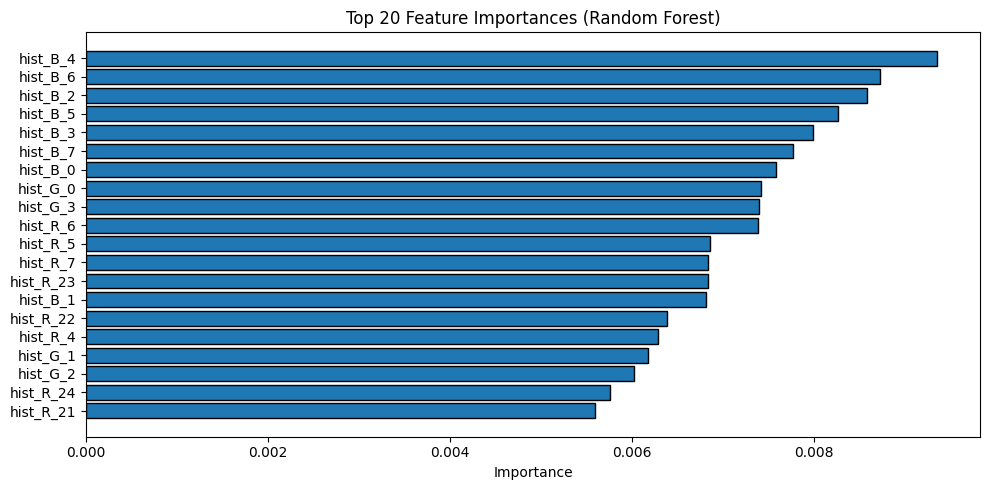

Saved top-20 feature importances plot to: /kaggle/working/feature_importances/top20_feature_importances.png

Top features:


feature  importance
0   hist_R_21    0.005591
1   hist_R_24    0.005760
2    hist_G_2    0.006022
3    hist_G_1    0.006172
4    hist_R_4    0.006278
5   hist_R_22    0.006377
6    hist_B_1    0.006810
7   hist_R_23    0.006832
8    hist_R_7    0.006837
9    hist_R_5    0.006860
10   hist_R_6    0.007381
11   hist_G_3    0.007390
12   hist_G_0    0.007413
13   hist_B_0    0.007578
14   hist_B_7    0.007765
15   hist_B_3    0.007990
16   hist_B_5    0.008263
17   hist_B_2    0.008577
18   hist_B_6    0.008720
19   hist_B_4    0.009355

In [12]:
#   Random Forest feature importances (top-20) + CSV export
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog

FEATURE_FILE = "/kaggle/working/features.npz"   # features saved earlier
OUT_DIR = "/kaggle/working/feature_importances"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load features and sample image path ----------
data = np.load(FEATURE_FILE, allow_pickle=True)
X_all = data["X"]
paths = data["paths"].astype(str)

print("Loaded features:", FEATURE_FILE)
print("Feature vector length:", X_all.shape[1])
n_features = X_all.shape[1]

# ---------- Try to reconstruct feature name split (hist bins vs HOG) ----------
 
hist_bins = None
hog_len = None
try:
    sample_img_path = paths[0]
    img = cv2.imread(sample_img_path)
    if img is None:
        raise RuntimeError("Failed to read sample image for inference of feature layout.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))   # default size used in previous cells
    chans = cv2.split(img)
    # attempt HIST_BINS candidates by checking divisibility with 3
    # but we will recompute using HIST_BINS=32 (the value used previously)
    HIST_BINS_TRY = 32
    hist_features = []
    for ch in chans:
        h = cv2.calcHist([ch], [0], None, [HIST_BINS_TRY], [0,256])
        h = cv2.normalize(h, h).flatten()
        hist_features.extend(h)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_feat = hog(gray, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
    hist_len = len(hist_features)
    hog_len = len(hog_feat)
    if hist_len + hog_len == n_features:
        hist_bins = HIST_BINS_TRY
        print(f"Detected feature split: hist_bins={hist_bins} (hist_len={hist_len}), hog_len={hog_len}")
    else:
        # try to infer hist_bins by checking small range of possible bins
        found = False
        for hb in (8, 16, 24, 32, 48, 64):
            hist_features_try = []
            for ch in chans:
                h = cv2.calcHist([ch], [0], None, [hb], [0,256])
                h = cv2.normalize(h, h).flatten()
                hist_features_try.extend(h)
            gl = len(hog_feat)
            if len(hist_features_try) + gl == n_features:
                hist_bins = hb
                hist_len = len(hist_features_try)
                hog_len = gl
                found = True
                print(f"Inferred hist_bins={hist_bins} (hist_len={hist_len}), hog_len={hog_len}")
                break
        if not found:
            print("Couldn't perfectly infer hist/hog split. Will fallback to generic feature names.")
except Exception as e:
    print("Auto-detection failed:", e)
    hist_bins = None
    hog_len = None

# ---------- Build feature names ----------
if hist_bins is not None:
    # color hist names: R_0..R_{B-1}, G_0.., B_0..
    names = []
    for ch in ("R", "G", "B"):
        for i in range(hist_bins):
            names.append(f"hist_{ch}_{i}")
    # HOG names
    for i in range(hog_len):
        names.append(f"HOG_{i}")
    if len(names) != n_features:
        # safety fallback
        names = [f"feat_{i}" for i in range(n_features)]
        print("Length mismatch after building names — using fallback generic names.")
else:
    names = [f"feat_{i}" for i in range(n_features)]
    print("Using generic feature names feat_0..feat_N")

# ---------- Get feature importances from RandomForest ----------
try:
    rf = gs.best_estimator_.named_steps["rf"]
except Exception:
    # fallback: try loading pipeline file
    import joblib
    p = "/kaggle/working/rf_plantvillage/rf_pipeline.joblib"
    if os.path.exists(p):
        pipeline = joblib.load(p)
        rf = pipeline.named_steps["rf"]
    else:
        raise RuntimeError("RandomForest model not found (gs.best_estimator_ not present and fallback file missing).")

importances = rf.feature_importances_
if importances.shape[0] != n_features:
    print(f"Warning: RF reported {importances.shape[0]} importances but X has {n_features} features.")
    # try to trim or pad
    if importances.shape[0] > n_features:
        importances = importances[:n_features]
    else:
        importances = np.concatenate([importances, np.zeros(n_features - importances.shape[0])])

# ---------- Create DataFrame of importances ----------
df_imp = pd.DataFrame({
    "feature": names,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# Save full CSV
csv_path = os.path.join(OUT_DIR, "feature_importances_full.csv")
df_imp.to_csv(csv_path, index=False)
print("Saved full feature importances to:", csv_path)

# ---------- Plot top-K (default top-20) ----------
TOP_K = 20
topk = df_imp.head(TOP_K).iloc[::-1]  # reverse for horizontal bar plot (small->big)
plt.figure(figsize=(10, max(4, TOP_K*0.25)))
plt.barh(topk["feature"], topk["importance"], edgecolor="k")
plt.xlabel("Importance")
plt.title(f"Top {TOP_K} Feature Importances (Random Forest)")
plt.tight_layout()
plot_path = os.path.join(OUT_DIR, "top20_feature_importances.png")
plt.savefig(plot_path, dpi=200)
plt.show()
print("Saved top-20 feature importances plot to:", plot_path)

# ---------- Print top features ----------
print("\nTop features:")
display(topk.reset_index(drop=True).round(6))
